# SI221 - TP K-nearest neighbors

Cohen Stephen 

### Données

Nous allons travailler sur des images de chiffres manuscrits (de 0 à 9), provenant du dataset MNIST. Ces images, de 28$\times$28 pixels, sont présentées comme des vecteurs lignes d'entiers compris entre $0$ et $255$. On y associe des étiquettes, indiquant quel est le chiffre représenté sur l'image (ici, l'étiquette correspondant au chiffre '0' est '10'. 

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.metrics import confusion_matrix
import datetime
from time import time
import itertools

In [2]:
# Careful, we need to convert the data to float - if we keep the encoding as 8-bit integer,
# we will certainly have issues when applying numpy functions to the data 
train_data = scipy.io.loadmat('data/data_app.mat')['x'].astype(np.float)
test_data = scipy.io.loadmat('data/data_test.mat')['x'].astype(np.float)
train_data = train_data.reshape(train_data.shape[0], 28, 28)
test_data = test_data.reshape(test_data.shape[0], 28, 28)

/tmp/ipykernel_3524058/2629779076.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_data = scipy.io.loadmat('data/data_app.mat')['x'].astype(np.float)
/tmp/ipykernel_3524058/2629779076.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_data = scipy.io.loadmat('data/data_test.mat')['x'].astype(np.float)


In [3]:
train_labels = scipy.io.loadmat('data/data_app.mat')['S'].reshape(-1)
test_labels = scipy.io.loadmat('data/data_test.mat')['S'].reshape(-1)

Quelle est la taille de l’ensemble d’entraînement et de l’ensemble de test ? Les exemples
sont-ils équirépartis suivant les classes ? Affichez les premières images de l'ensemble d'entraînement ainsi que les étiquettes correspondantes. 

**Réponses:**

- on a 1000 images d'entraînement et 300 de test
- les exemples du train set sont plutôt bien répartis entre nos 10 classes

Train set size : 1000
Test set size : 300


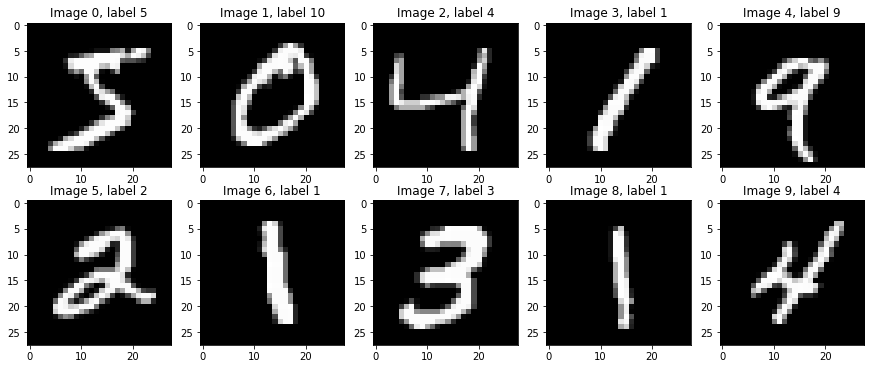

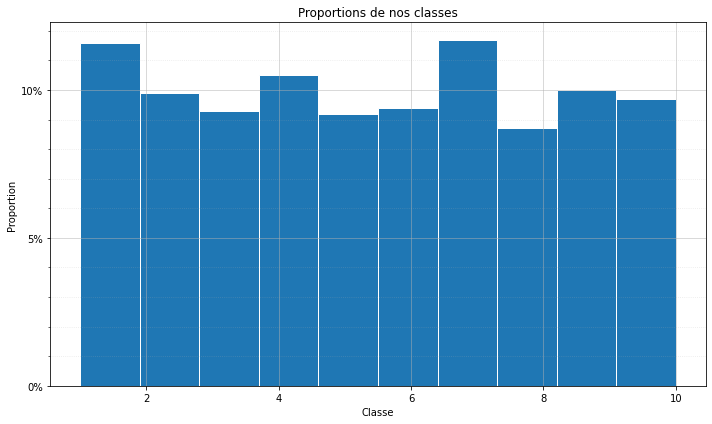

In [4]:
print(f'Train set size : {train_labels.size}')
print(f'Test set size : {test_labels.size}')

train_images = train_data.reshape((train_labels.size, 28, 28))

fig,axes=plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

# on affiche 10 images notre dataset
for i in range(10):
    ax[i].imshow(train_images[i], cmap='gray')
    ax[i].set_title(f'Image {i}, label {train_labels[i]}')
plt.show()


# Regardons les proportions de nos classes
fig,ax=plt.subplots(figsize=(10,6))

major_ticks_y=np.linspace(0,1,21)
minor_ticks_y=np.linspace(0,1,101)

ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y,minor=True)
ax.set_title("Proportions de nos classes")
ax.grid(which="major",alpha=0.6)
ax.grid(which="minor",alpha=0.3,linestyle=':')
ax.hist(train_labels, weights=np.ones_like(train_labels)/len(train_labels), edgecolor="white")
ax.set_xlabel('Classe')
ax.set_ylabel('Proportion')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
plt.tight_layout()
plt.show()

Implémentez la méthode des $k$-plus proche voisins en prenant comme caractéristiques les valeurs des
pixels. On donnera, pour différentes valeurs du paramètre k (k=1, 3, 4, 5):
- Le taux d’erreur.
- La matrice de confusion - La matrice de confusion est une matrice de taille $10\times10$ dont l’élément d’indice (i,j) est le nombre de vecteurs de la classe i qui ont été affectés à la classe j par la méthode.
- Visualisez quelques confusions entre caractères.

In [5]:
def knn(k,test,train,labels):
    pred = np.zeros(test.shape[0])
    for i in range(test.shape[0]):
        image = test[i]
        # distances à chaque image dans l’ensemble d’entraînement (Norm 2)
        distances=np.zeros(train.shape[0])
        for j in range(distances.size):
            distances[j]= np.linalg.norm(train[j,:] - image)

        # obtenir les distances les plus proches
        distances_ord, lab = zip(*sorted(zip(distances, labels)))
        knn=lab[0:k]
        # obtenir la classe la plus fréquente entre les voisins les plus proches
        counts = np.bincount(knn)
        pred[i]= np.argmax(counts)
    return pred

In [6]:
#Définir une fonction permettant d'afficher les matrices de confusions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    print(f'Taux d\'erreur : {1-np.trace(cm)/np.sum(cm):.2%}%')
    return 1-np.trace(cm)/np.sum(cm)

In [7]:
def format_duration(duration):
    td = datetime.timedelta(seconds=duration)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = td.microseconds
    seconds += microseconds / 1000000

    parts = []
    if td.days > 0:
        parts.append(f'{td.days}d')
    if hours > 0:
        parts.append(f'{hours}h')
    if minutes > 0:
        parts.append(f'{minutes}min')
    if seconds > 1:
        parts.append(f'{seconds:.2f}s')
    elif not parts:
        parts.append(f'{microseconds/1000:.2f}ms')

    return ' '.join(parts)

KNN avec k=1
Done in 4.01s


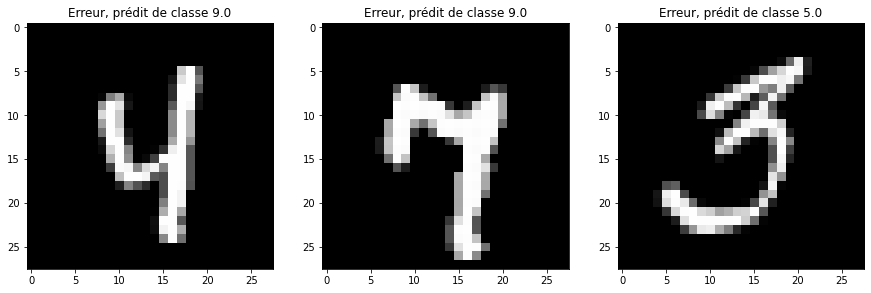

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07142857 0.82142857 0.         0.03571429 0.         0.
  0.03571429 0.03571429 0.         0.        ]
 [0.         0.10714286 0.60714286 0.         0.17857143 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.02631579 0.         0.         0.65789474 0.         0.05263158
  0.         0.02631579 0.23684211 0.        ]
 [0.         0.         0.08333333 0.         0.75       0.04166667
  0.         0.04166667 0.04166667 0.04166667]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.05882353 0.
  0.91176471 0.         0.02941176 0.        ]
 [0.03225806 0.         0.03225806 0.03225806 0.         0.03225806
  0.         0.83870968 0.03225806 0.        ]
 [0.         0.         0.         0.0625     0.         0.
  0.03125    0.         0.90625 

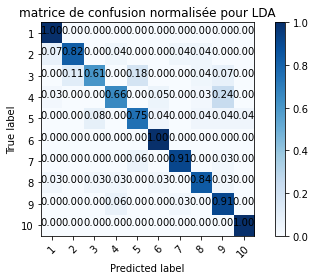

KNN avec k=2
Done in 3.15s


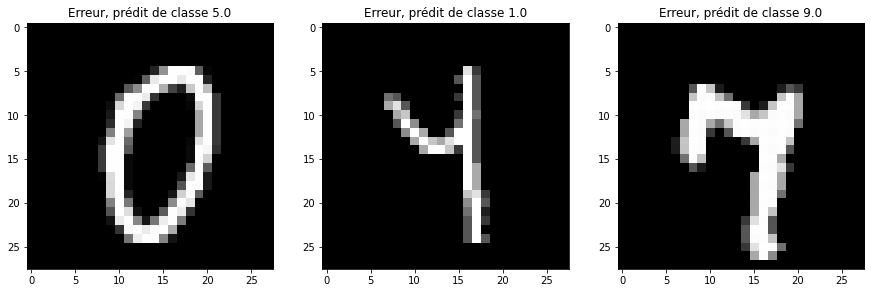

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07142857 0.82142857 0.         0.03571429 0.03571429 0.
  0.03571429 0.         0.         0.        ]
 [0.         0.14285714 0.60714286 0.         0.14285714 0.
  0.03571429 0.         0.07142857 0.        ]
 [0.07894737 0.05263158 0.         0.78947368 0.         0.
  0.         0.         0.07894737 0.        ]
 [0.         0.         0.16666667 0.         0.79166667 0.04166667
  0.         0.         0.         0.        ]
 [0.12       0.         0.         0.         0.         0.88
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.05882353 0.02941176 0.
  0.88235294 0.         0.02941176 0.        ]
 [0.06451613 0.03225806 0.09677419 0.03225806 0.06451613 0.03225806
  0.         0.64516129 0.03225806 0.        ]
 [0.         0.         0.         0.0625     0.         0.
  0.0625     0.03125    0.84375    0. 

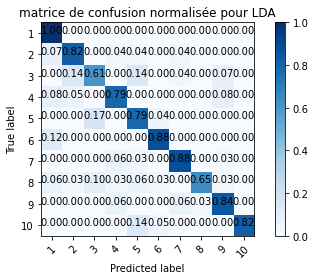

KNN avec k=3
Done in 3.79s


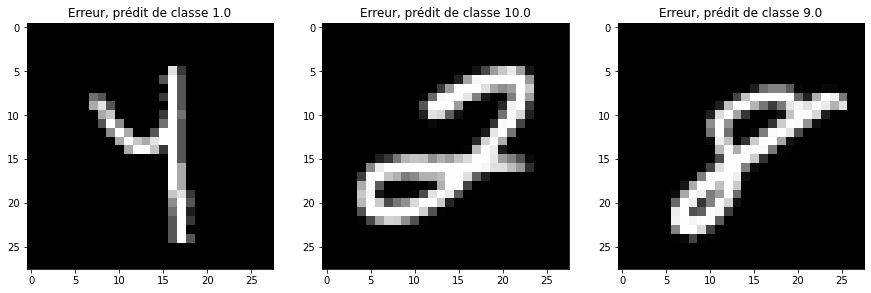

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07142857 0.75       0.         0.         0.03571429 0.
  0.03571429 0.         0.03571429 0.07142857]
 [0.         0.14285714 0.53571429 0.         0.25       0.
  0.         0.         0.07142857 0.        ]
 [0.07894737 0.02631579 0.         0.71052632 0.         0.05263158
  0.         0.         0.13157895 0.        ]
 [0.         0.         0.125      0.         0.83333333 0.04166667
  0.         0.         0.         0.        ]
 [0.08       0.         0.         0.         0.         0.92
  0.         0.         0.         0.        ]
 [0.         0.         0.02941176 0.08823529 0.02941176 0.
  0.82352941 0.         0.02941176 0.        ]
 [0.03225806 0.03225806 0.03225806 0.         0.03225806 0.03225806
  0.         0.77419355 0.06451613 0.        ]
 [0.         0.         0.03125    0.         0.         0.
  0.03125    0.         0.9375

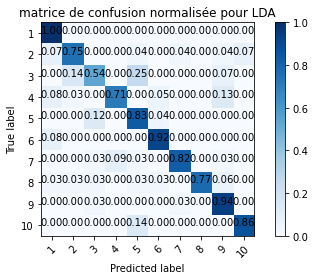

KNN avec k=4
Done in 3.34s


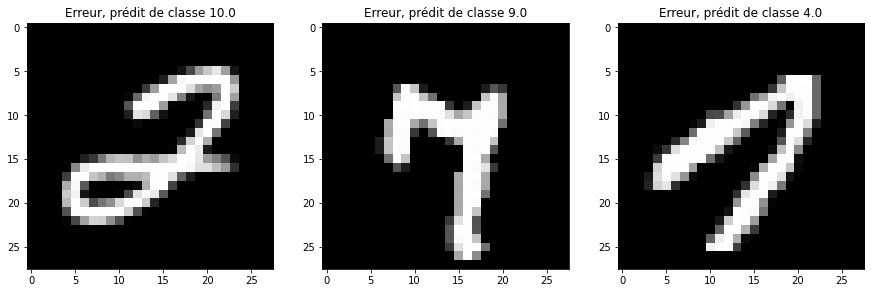

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10714286 0.78571429 0.         0.03571429 0.         0.
  0.03571429 0.         0.         0.03571429]
 [0.         0.03571429 0.64285714 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.05263158 0.02631579 0.         0.76315789 0.         0.05263158
  0.         0.         0.10526316 0.        ]
 [0.         0.         0.125      0.04166667 0.75       0.04166667
  0.         0.         0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.05882353 0.05882353 0.
  0.85294118 0.         0.02941176 0.        ]
 [0.03225806 0.03225806 0.06451613 0.         0.03225806 0.03225806
  0.         0.77419355 0.03225806 0.        ]
 [0.         0.         0.03125    0.03125    0.         0.
  0.03125    0.         0.9062

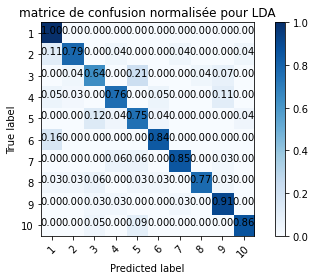

KNN avec k=5
Done in 3.16s


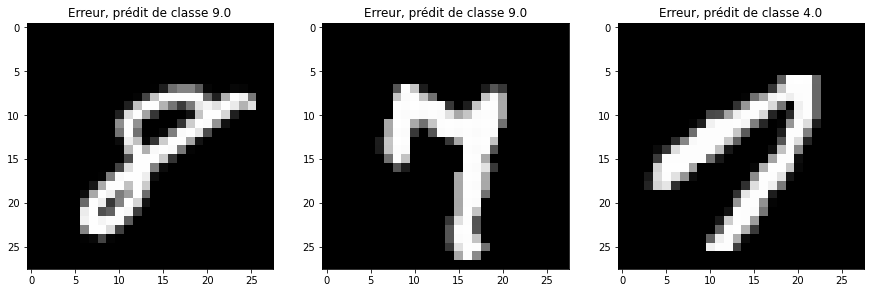

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07142857 0.82142857 0.         0.         0.03571429 0.
  0.03571429 0.         0.03571429 0.        ]
 [0.         0.07142857 0.60714286 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.02631579 0.         0.76315789 0.         0.02631579
  0.         0.         0.10526316 0.        ]
 [0.         0.         0.08333333 0.04166667 0.83333333 0.
  0.         0.         0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.05882353 0.05882353 0.
  0.85294118 0.         0.02941176 0.        ]
 [0.03225806 0.03225806 0.06451613 0.06451613 0.03225806 0.03225806
  0.         0.70967742 0.03225806 0.        ]
 [0.         0.         0.03125    0.         0.         0.
  0.03125    0.         0.9375     0. 

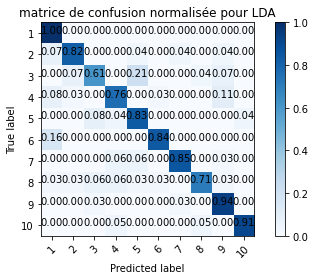

KNN avec k=6
Done in 3.38s


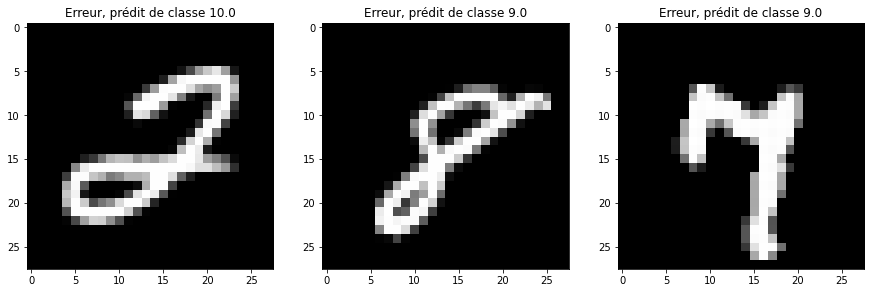

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10714286 0.75       0.         0.         0.03571429 0.
  0.03571429 0.         0.03571429 0.03571429]
 [0.03571429 0.03571429 0.60714286 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.02631579 0.         0.73684211 0.         0.02631579
  0.         0.         0.13157895 0.        ]
 [0.         0.         0.08333333 0.08333333 0.79166667 0.
  0.         0.         0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.05882353 0.         0.         0.05882353 0.02941176 0.
  0.79411765 0.         0.05882353 0.        ]
 [0.03225806 0.03225806 0.12903226 0.03225806 0.         0.03225806
  0.         0.70967742 0.03225806 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.03125    0.03125    0.9375     0. 

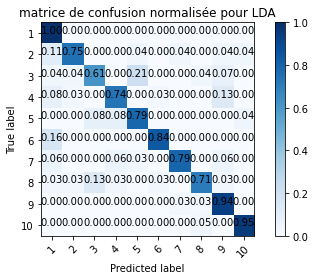

KNN avec k=7
Done in 3.00s


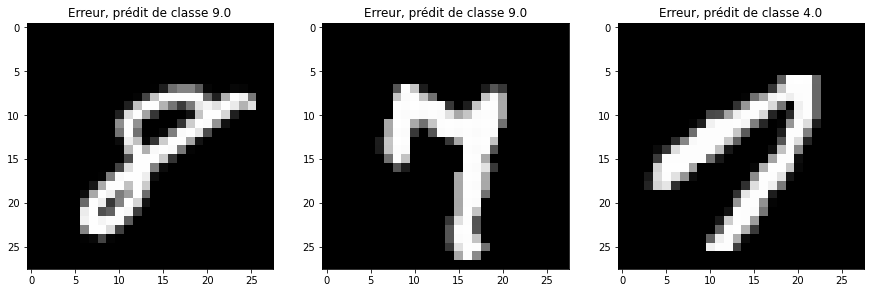

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.14285714 0.78571429 0.         0.         0.         0.
  0.03571429 0.         0.03571429 0.        ]
 [0.07142857 0.         0.57142857 0.         0.25       0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.         0.         0.76315789 0.         0.02631579
  0.         0.         0.13157895 0.        ]
 [0.         0.         0.08333333 0.08333333 0.75       0.
  0.         0.04166667 0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.05882353 0.         0.         0.05882353 0.02941176 0.
  0.82352941 0.         0.02941176 0.        ]
 [0.03225806 0.03225806 0.09677419 0.03225806 0.03225806 0.03225806
  0.03225806 0.64516129 0.06451613 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.03125    0.03125    0.9375     0. 

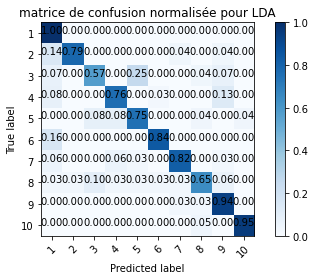

KNN avec k=8
Done in 3.76s


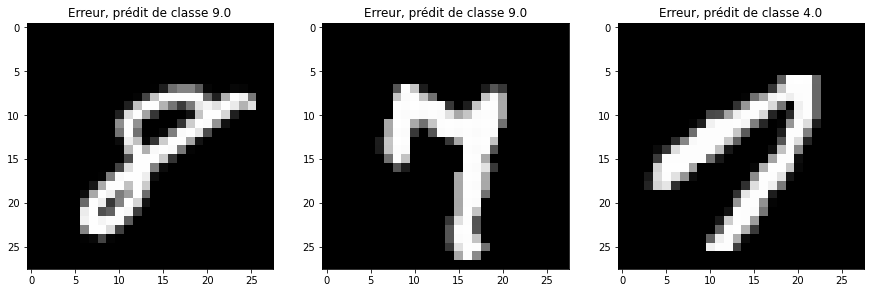

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.17857143 0.71428571 0.         0.         0.03571429 0.
  0.03571429 0.         0.03571429 0.        ]
 [0.07142857 0.03571429 0.57142857 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.         0.         0.76315789 0.         0.02631579
  0.         0.         0.13157895 0.        ]
 [0.04166667 0.         0.         0.08333333 0.83333333 0.
  0.         0.         0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.05882353 0.         0.         0.05882353 0.02941176 0.
  0.82352941 0.         0.02941176 0.        ]
 [0.03225806 0.         0.09677419 0.06451613 0.         0.03225806
  0.03225806 0.67741935 0.06451613 0.        ]
 [0.         0.         0.         0.03125    0.         0.
  0.03125    0.03125    0.90625    0. 

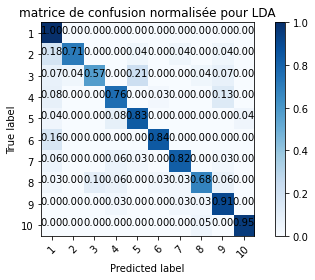

KNN avec k=9
Done in 3.16s


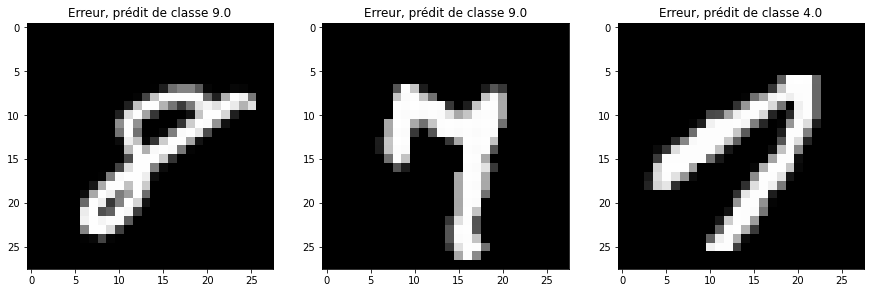

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.17857143 0.75       0.         0.         0.         0.
  0.03571429 0.         0.03571429 0.        ]
 [0.07142857 0.03571429 0.57142857 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.         0.         0.76315789 0.         0.02631579
  0.         0.         0.13157895 0.        ]
 [0.08333333 0.         0.08333333 0.04166667 0.75       0.
  0.         0.         0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.05882353 0.         0.         0.05882353 0.02941176 0.
  0.79411765 0.         0.05882353 0.        ]
 [0.03225806 0.         0.06451613 0.06451613 0.03225806 0.03225806
  0.03225806 0.64516129 0.09677419 0.        ]
 [0.         0.         0.         0.03125    0.         0.
  0.03125    0.03125    0.90625    0. 

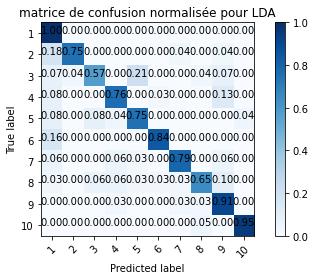

KNN avec k=10
Done in 3.44s


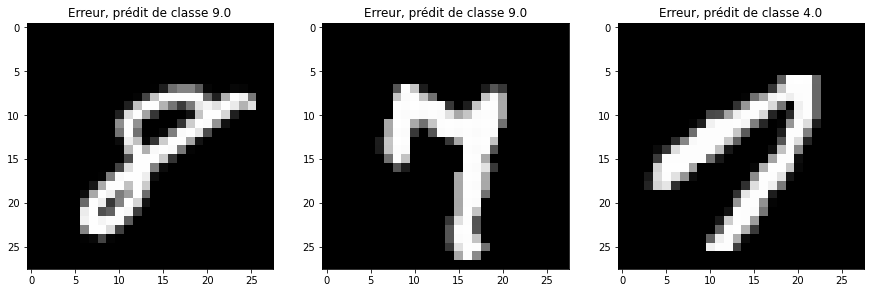

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.17857143 0.75       0.         0.         0.         0.
  0.03571429 0.         0.03571429 0.        ]
 [0.07142857 0.03571429 0.57142857 0.         0.21428571 0.
  0.         0.03571429 0.07142857 0.        ]
 [0.07894737 0.         0.         0.76315789 0.         0.02631579
  0.         0.         0.13157895 0.        ]
 [0.04166667 0.         0.04166667 0.04166667 0.79166667 0.
  0.         0.04166667 0.         0.04166667]
 [0.16       0.         0.         0.         0.         0.84
  0.         0.         0.         0.        ]
 [0.05882353 0.         0.         0.05882353 0.02941176 0.
  0.79411765 0.         0.05882353 0.        ]
 [0.03225806 0.         0.06451613 0.03225806 0.         0.03225806
  0.03225806 0.74193548 0.06451613 0.        ]
 [0.         0.         0.         0.0625     0.         0.
  0.         0.03125    0.90625    0. 

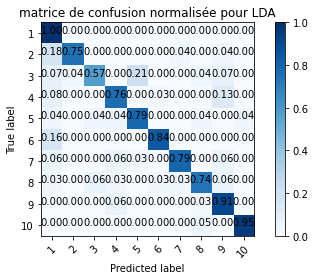

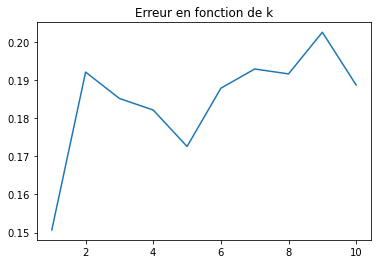

In [8]:
erreur = []
for k in range(1, 11):
    print(f"KNN avec k={k}")
    t0 = time()
    y_pred = knn(k, test_data, train_data, train_labels)
    print(f"Done in {format_duration(time() - t0)}")
    
    fausses_pred = (y_pred != test_labels)
    #visualisation
    fig,axes=plt.subplots(ncols=3, figsize=(15,6))
    ax = axes.ravel()

    # on affiche les prototypes
    for i in range(min(len(fausses_pred), 3)):
        ax[i].imshow(test_data[fausses_pred][i], cmap='gray')
        ax[i].set_title(f'Erreur, prédit de classe {y_pred[fausses_pred][i]}')
    plt.show()

    # confusion matrix
    cnf_matrix = confusion_matrix(test_labels, y_pred)

    # normalized confusion matrix
    plt.figure()
    err = plot_confusion_matrix(cnf_matrix, classes=[i for i in range(1, 11)], normalize=True,
                          title='matrice de confusion normalisée pour LDA')
    erreur.append(err)
    plt.show()

plt.plot(np.arange(1, 11, 1), erreur)
plt.title("Erreur en fonction de k")
plt.show()

- Construisez des prototypes (au moins un par classe) à partir des images de l’ensemble d’apprentissage, et visualisez-les. Le prototype peut être par exemple la moyenne des exemples correspondants à chaque classe. 
- Classez les images de test en les comparant aux prototypes.
- Comparez avec les résultats obtenus précedemment.

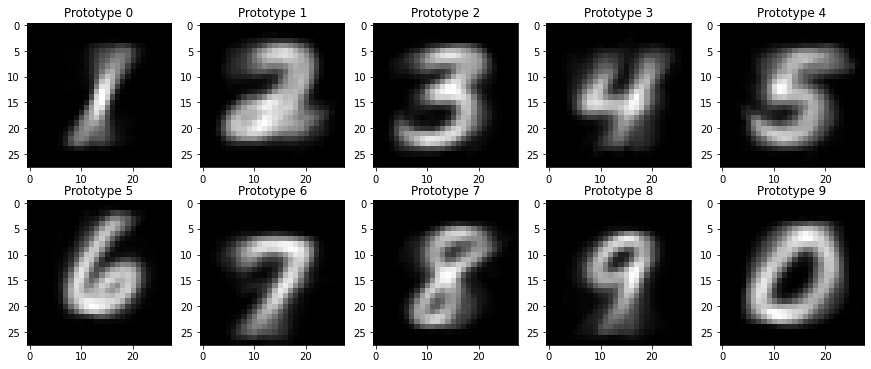

In [9]:
#creer des prototypes
sums = np.zeros((10,28,28))
occur = np.zeros(10)

for i in range(train_labels.size):
    occur[train_labels[i]-1] += 1
    sums[train_labels[i]-1, : , :] += train_data[i, : , :]       
prototypes = np.array([sums[i, :, :] / occur[i] for i in range(10)])

#visualisation
fig,axes=plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

# on affiche les prototypes
for i in range(10):
    ax[i].imshow(prototypes[i], cmap='gray')
    ax[i].set_title(f'Prototype {i}')
plt.show()

KNN avec k=1
Done in 41.84ms
Normalized confusion matrix
[[0.94736842 0.         0.         0.         0.         0.
  0.         0.05263158 0.         0.        ]
 [0.10714286 0.82142857 0.         0.         0.         0.03571429
  0.         0.03571429 0.         0.        ]
 [0.03571429 0.17857143 0.42857143 0.         0.21428571 0.
  0.         0.03571429 0.10714286 0.        ]
 [0.02631579 0.         0.         0.73684211 0.02631579 0.02631579
  0.         0.         0.18421053 0.        ]
 [0.08333333 0.         0.125      0.04166667 0.66666667 0.
  0.         0.04166667 0.04166667 0.        ]
 [0.12       0.         0.         0.04       0.08       0.76
  0.         0.         0.         0.        ]
 [0.02941176 0.         0.         0.05882353 0.02941176 0.
  0.82352941 0.         0.05882353 0.        ]
 [0.06451613 0.03225806 0.12903226 0.         0.06451613 0.
  0.03225806 0.64516129 0.03225806 0.        ]
 [0.         0.         0.         0.1875     0.03125    0.
  0.03125

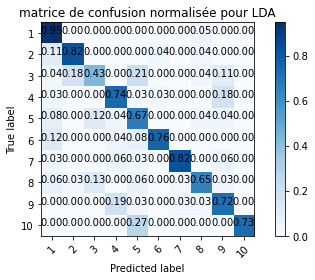

KNN avec k=2
Done in 30.59ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.14285714 0.85714286 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07142857 0.21428571 0.57142857 0.03571429 0.10714286 0.
  0.         0.         0.         0.        ]
 [0.02631579 0.07894737 0.         0.81578947 0.05263158 0.
  0.         0.02631579 0.         0.        ]
 [0.125      0.04166667 0.375      0.04166667 0.41666667 0.
  0.         0.         0.         0.        ]
 [0.16       0.24       0.         0.08       0.4        0.12
  0.         0.         0.         0.        ]
 [0.08823529 0.         0.         0.20588235 0.         0.
  0.70588235 0.         0.         0.        ]
 [0.16129032 0.16129032 0.32258065 0.         0.06451613 0.03225806
  0.03225806 0.22580645 0.         0.        ]
 [0.09375    0.03125    0.03125    0.46875    0.         0.
  0.34375    0.03

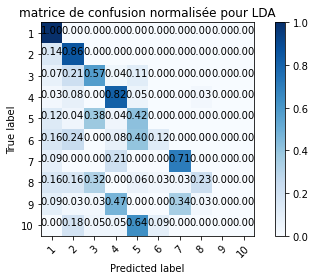

KNN avec k=3
Done in 26.82ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.25       0.75       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.14285714 0.32142857 0.42857143 0.07142857 0.03571429 0.
  0.         0.         0.         0.        ]
 [0.05263158 0.21052632 0.         0.73684211 0.         0.
  0.         0.         0.         0.        ]
 [0.20833333 0.16666667 0.375      0.04166667 0.20833333 0.
  0.         0.         0.         0.        ]
 [0.2        0.52       0.         0.08       0.2        0.
  0.         0.         0.         0.        ]
 [0.14705882 0.         0.08823529 0.55882353 0.05882353 0.
  0.14705882 0.         0.         0.        ]
 [0.22580645 0.29032258 0.32258065 0.03225806 0.09677419 0.
  0.03225806 0.         0.         0.        ]
 [0.09375    0.0625     0.03125    0.65625    0.0625     0.
  0.09375    0.         0. 

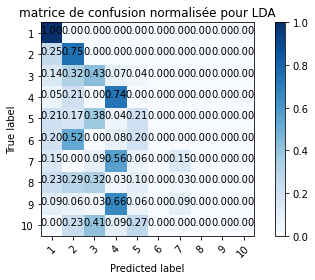

KNN avec k=4
Done in 28.90ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.28571429 0.71428571 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.25       0.39285714 0.25       0.07142857 0.03571429 0.
  0.         0.         0.         0.        ]
 [0.05263158 0.28947368 0.10526316 0.55263158 0.         0.
  0.         0.         0.         0.        ]
 [0.25       0.25       0.29166667 0.08333333 0.125      0.
  0.         0.         0.         0.        ]
 [0.24       0.56       0.         0.08       0.12       0.
  0.         0.         0.         0.        ]
 [0.23529412 0.         0.20588235 0.52941176 0.02941176 0.
  0.         0.         0.         0.        ]
 [0.32258065 0.38709677 0.22580645 0.03225806 0.         0.03225806
  0.         0.         0.         0.        ]
 [0.125      0.125      0.03125    0.625      0.09375    0.
  0.         0.    

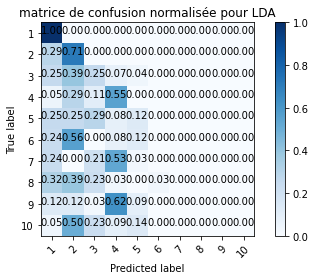

KNN avec k=5
Done in 52.01ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.35714286 0.64285714 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.35714286 0.39285714 0.25       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07894737 0.42105263 0.21052632 0.28947368 0.         0.
  0.         0.         0.         0.        ]
 [0.29166667 0.33333333 0.25       0.04166667 0.08333333 0.
  0.         0.         0.         0.        ]
 [0.28       0.68       0.04       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.32352941 0.08823529 0.35294118 0.23529412 0.         0.
  0.         0.         0.         0.        ]
 [0.32258065 0.58064516 0.06451613 0.03225806 0.         0.
  0.         0.         0.         0.        ]
 [0.125      0.21875    0.15625    0.5        0.         0.
  0.         0.         0. 

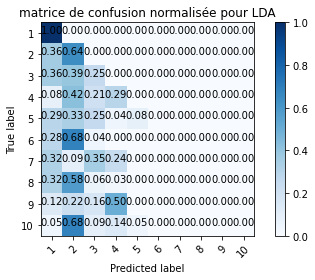

KNN avec k=6
Done in 65.48ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.42857143 0.57142857 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.42857143 0.35714286 0.21428571 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10526316 0.55263158 0.18421053 0.15789474 0.         0.
  0.         0.         0.         0.        ]
 [0.29166667 0.54166667 0.16666667 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.32       0.68       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.38235294 0.20588235 0.38235294 0.02941176 0.         0.
  0.         0.         0.         0.        ]
 [0.35483871 0.58064516 0.06451613 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.28125    0.3125     0.25       0.15625    0.         0.
  0.         0.         0. 

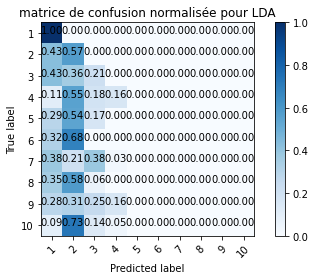

KNN avec k=7
Done in 27.57ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.57142857 0.42857143 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.60714286 0.32142857 0.07142857 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.23684211 0.65789474 0.10526316 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.33333333 0.625      0.04166667 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48       0.52       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.52941176 0.26470588 0.17647059 0.02941176 0.         0.
  0.         0.         0.         0.        ]
 [0.4516129  0.5483871  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.34375    0.46875    0.1875     0.         0.         0.
  0.         0.         0. 

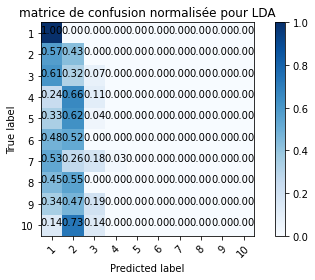

KNN avec k=8
Done in 41.83ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.64285714 0.35714286 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.67857143 0.32142857 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.47368421 0.52631579 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.45833333 0.5        0.04166667 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.56       0.44       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.64705882 0.26470588 0.08823529 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48387097 0.51612903 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46875    0.53125    0.         0.         0.         0.
  0.         0.         0. 

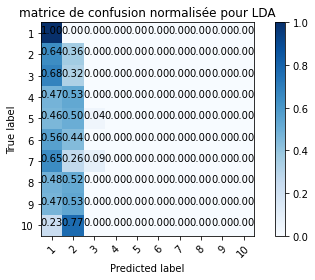

KNN avec k=9
Done in 26.94ms
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.82142857 0.17857143 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.89285714 0.10714286 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.60526316 0.39473684 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.70833333 0.29166667 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.72       0.28       0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.76470588 0.23529412 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.61290323 0.38709677 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.75       0.25       0.         0.         0.         0.
  0.         0.         0. 

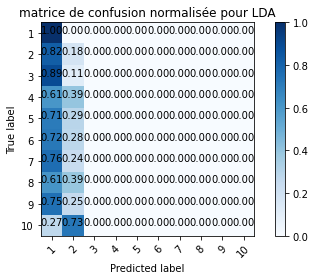

KNN avec k=10
Done in 30.39ms
Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Taux d'erreur : 90.00%%


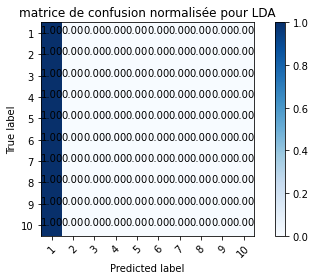

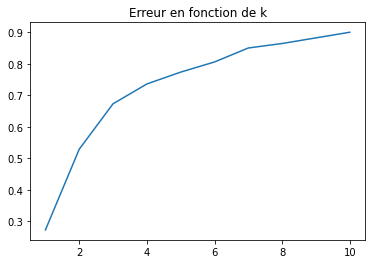

In [10]:
erreur = []
for k in range(1, 11):
    print(f"KNN avec k={k}")
    t0 = time()
    y_pred = knn(k, test_data, prototypes, [i for i in range(1, 11)])
    print(f"Done in {format_duration(time() - t0)}")
    
    # confusion matrix
    cnf_matrix = confusion_matrix(test_labels, y_pred)

    # normalized confusion matrix
    plt.figure()
    err = plot_confusion_matrix(cnf_matrix, classes=[i for i in range(1, 11)], normalize=True,
                          title='matrice de confusion normalisée pour LDA')
    erreur.append(err)
    plt.show()

plt.plot(np.arange(1, 11, 1), erreur)
plt.title("Erreur en fonction de k")
plt.show()

**Réponse:**

Les résultats sont clairement moins bons, mais beaucoup plus rapides !